In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import dashi as d
d.visual()
import numpy as n
import seaborn as sns
sns.set_style("ticks")
import cPickle as pickle

from NNMFit import AnalysisConfig
from NNMFit import PoissLLH, binning
from NNMFit import loaders

from collections import defaultdict

from theano import function

In [10]:
det_config = "IC86-2011"
#overrd = ["IC86-2011_lowE.cfg"]

config = AnalysisConfig(
            ["default.cfg"])

"""
config = AnalysisConfig(
    ["default.cfg"],
    override_configs = overrd,
    override={"main": {"use_alignment": "False",
                       "analysis_variables": "reco_energy, reco_zenith",
                       "oversampling": "False"}}
)
"""



loader = loaders.Loader(config, [det_config])
expec_hdls = loader.make_expectation_handlers()
llh = PoissLLH(loader, expec_hdls, profile=False)



In [11]:
def make_flux_for_comp(comp, expec_hdl):
    
    graph  = expec_hdl.make_graph_and_apply_sys(comp, expec_hdl._fluxes[comp].uses_3d)
    
    if not loader.global_settings.binned_systematics:
        oversampling_flag = None
        if expec_hdl._oversampling:
            if expec_hdl._fluxes[comp].uses_3d:
                oversampling_flag = "over"
            else:
                oversampling_flag = "repeat"
        graph = binning.make_binned_flux(graph, 
                                         expec_hdl._binning,
                                         expec_hdl._indices_flattened,
                                         oversampling_flag)   
    total_binned = graph * loader.settings[det_config].livetime
    
    return total_binned



expec_functions = defaultdict(dict)

for det_conf, expec_hdl in expec_hdls.iteritems():
    for flux_name in loader.global_settings.fluxes.keys():

        flux_total_binned = make_flux_for_comp(flux_name, expec_hdl)
        expec_functions[flux_name][det_conf] = function(llh._input_variables,
                                              flux_total_binned, 
                                              allow_input_downcast=True,
                                              on_unused_input="ignore")


In [3]:
rates, rate_errors, values, baseline_index = loaders.load_kde_sys_datasets(det_config,
                                                                           config,
                                                                           "honda2006_gaisserH4a_elbert_v2",
                                                                           "dom_eff")
rates2, rate_errors, values, baseline_index = loaders.load_kde_sys_datasets(det_config,
                                                                           config,
                                                                           #"honda2006_gaisserH4a_elbert_v2",
                                                                           "powerlaw",
                                                                            "dom_eff")


In [4]:
print rates
print loaders.make_binned_rates(dataset_dict[det_config], rates, rate_errors)

[[ 0.00085379  0.0012047   0.00165193]
 [ 0.00031403  0.00043282  0.00057491]
 [ 0.00065874  0.00089831  0.00117735]
 ..., 
 [ 0.0005097   0.00070446  0.0009711 ]
 [ 0.00030605  0.00027321  0.000215  ]
 [ 0.00058072  0.00073287  0.00096622]]
(array([[ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.00554675,  0.00550726,  0.00488267],
       ..., 
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ]]), array([[ 1.        ,  1.        ,  1.        ],
       [ 1.        ,  1.        ,  1.        ],
       [ 0.00251399,  0.00246611,  0.00216179],
       ..., 
       [ 1.        ,  1.        ,  1.        ],
       [ 1.        ,  1.        ,  1.        ],
       [ 1.        ,  1.        ,  1.        ]]))


In [29]:
qint = systematics.eventwise_reweighting.quad_interp()
qint.fit(values, 
         n.atleast_2d(binned_rates),
          n.atleast_2d(binned_errors))

deff = dscalar()

func = function([deff], qint.eval(deff))

0.015625974332355595

In [7]:
print deff._baseline_rate.eval()
print binned_rates
print rates

[  0.00000000e+00   0.00000000e+00   6.84625447e-05 ...,   0.00000000e+00
   0.00000000e+00   0.00000000e+00]
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.00554675  0.00550726  0.00488267]
 ..., 
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
[[ 0.00085379  0.0012047   0.00165193]
 [ 0.00031403  0.00043282  0.00057491]
 [ 0.00065874  0.00089831  0.00117735]
 ..., 
 [ 0.0005097   0.00070446  0.0009711 ]
 [ 0.00030605  0.00027321  0.000215  ]
 [ 0.00058072  0.00073287  0.00096622]]


[             nan              nan   6.84625440e-05 ...,              nan
              nan              nan]
[7.932762666685683, -17.781205046427164, 6.1291647749743499]


NameError: name 'func' is not defined

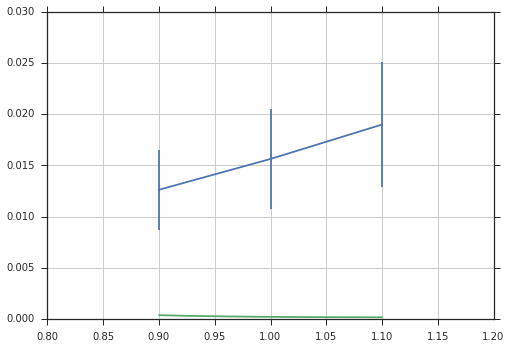

In [5]:

deff = det_systematics[det_config]._systematics["conventional"]["dom_eff"]


a,b,c =deff._interpolator.par_T

print (deff.make_graph(1)* deff._baseline_rate).eval()
rates, rate_errors, values, baseline_index = loaders.load_kde_sys_datasets(det_config,
                                                                           config,
                                                                           config["conventional"]["baseline_weights"],
                                                                          "dom_eff")

binned_rates, binned_errors = loaders.make_binned_rates(dataset_dict[det_config], rates, rate_errors)

def ffunc(x, par):
    return par[0]*x**2 + par[1]*x + par[2]

index = 3
pars=[a.get_value()[index], b.get_value()[index], c.get_value()[index]]
print pars
plt.errorbar(values, binned_rates[index], binned_errors[index])
plt.xlim(0.8,1.2)
plt.grid()

xs_eval = n.linspace(0.9,1.1,100)
plt.plot(xs_eval, 10**ffunc(xs_eval, pars))
for x in xs_eval:
    plt.plot(x, func(x)[index],"o")

[]

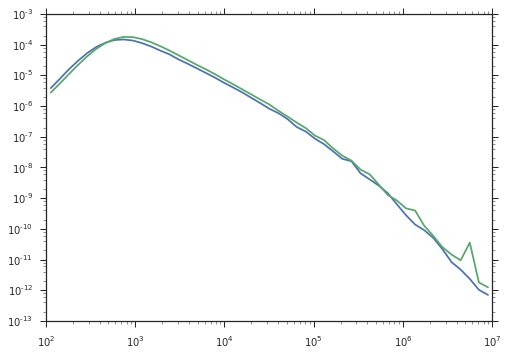

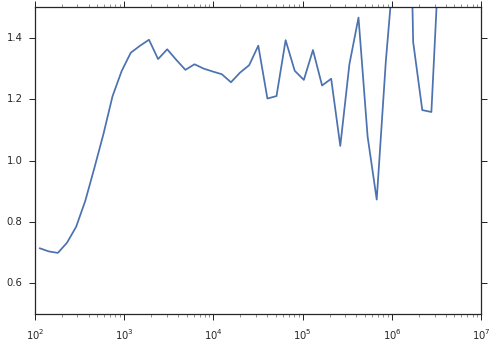

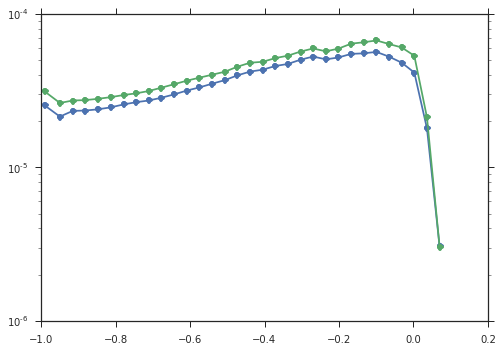

In [12]:
"""
graph = det_systematics[det_config].make_graph("conventional")
in_vars = syste.get_input_vars()
rw_func = function(in_vars, graph)
"""

deff = scalar()
graph = det_systematics[det_config]._systematics["conventional"]["dom_eff"].make_graph(deff)

rw_func = function([deff], graph)

binning = dataset_dict[det_conf][2]
ds = dataset_dict[det_conf][0]
bc = dataset_dict[det_conf][3]
#print in_vars

baseline_weights = config["conventional"]["baseline_weights"]

h,_,__,___ = scipy.stats.binned_statistic_2d(ds.reco_energy,ds.reco_zenith,
                                             ds.weight(baseline_weights) * rw_func(0.9),
                                             statistic="sum", bins = binning[:2])
h_base,_,__,___ = scipy.stats.binned_statistic_2d(ds.reco_energy,ds.reco_zenith,
                                             ds.weight(baseline_weights),
                                             statistic="sum", bins = binning[:2])

plt.plot(bc[0], h.sum(axis=1))
plt.plot(bc[0], h_base.sum(axis=1))
plt.loglog()
plt.figure()
plt.plot(bc[0], h_base.sum(axis=1)/h.sum(axis=1))
plt.semilogx()
plt.ylim(0.5,1.5)

plt.figure()
plt.plot(n.cos(bc[1]), h.sum(axis=0),"o-")
plt.plot(n.cos(bc[1]), h_base.sum(axis=0),"o-")
plt.semilogy()